<div align="center">
<font color=0F5298 size=5>
A Fine-tuned Embedding on Fake News Dataset
</font> <br>

<font color=2565AE size=2>
 Natural Language Processing Course - Task 3
</font> <br>

<font color=2565AE size=3>
 Sharif University of Technology - Fall 2023
</font> <br>
<font color=3C99D size=4>
 Contributers: Benyamin Maleki - Sina Namazi - Erfan Sadrayieh
</font> <br>
</div>


To start the project you need to first install the following modules and import them.

In [ ]:
## installation
%pip install sentence-transformers -q


## imports
# sentence bert
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer

# tools
from google.colab import drive
from tqdm import tqdm
import csv
from itertools import chain
# base
import numpy as np
import pandas as pd
# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
# sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA



First we load our pretrained embedding model. We have used sentence bert.


In [ ]:
PRE_TRAIN = False

if PRE_TRAIN:
  pretrained_model = SentenceTransformer('all-mpnet-base-v2')
  device = "mps" if torch.backends.mps.is_available() else "cpu"
  pretrained_model = pretrained_model.to(device)

The following block will encode the news data that we have, but it can be skipped in the next runs of your project, as it will be uploaded to your drive.


In [ ]:
if PRE_TRAIN:
  WRITE_MODE = False
  text_entries = []
  label_entries = []

  with open('fake-news/train.csv', 'r') as csvfile:
      reader = csv.reader(csvfile)
      for row in reader:
          text_entries.append('Title:'+row[1]+'\nAuthor:'+row[2]+'\nBody:'+row[3])
          label_entries.append(row[4])
  text_entries = text_entries[1:]
  label_entries = label_entries[1:]

  batch_size = 64
  encoded_vectors = []
  for i in tqdm(range(0, len(text_entries), batch_size)):
      encoded_vectors.extend(pretrained_model.encode(text_entries[i:i+batch_size]))

  if WRITE_MODE:
    with open('x_train_embedded2.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerows(encoded_vectors)

    with open('x_train_embedded2.csv', 'r') as csvfile:
      reader = csv.reader(csvfile)
      s = 0
      for row in reader:
          s+=1
      if len(text_entries) == s:
        print("All data has been written successfully:", s, "entries")


    list_of_lists = [[label] for label in label_entries]
    with open('y_train_embedded2.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerows(list_of_lists)

<p> Now we define our dataset and model so that torch can understand them and work with them. </p>

<p> make_pairs function, pairs the data points, randomly, but keeps this property that we should have a negative and a positive pair per the selected base intial point. We make sure that at least one pair is created per data point by iterating over the whole dataset.</p>
<p> A negative pair is pair which the fake label of them differ. In contrast, a positive pair is a pair which both of its elements have the same fake/truth label. </p>

<p> We have used batch normalizer and dropout layers in addition to simple linear hidden layers, each of which activated by ReLU. The architecture of our model follows Siamese which relies on contrasive loss. Breifly, it tries to minimize the (euclidian) distance of positive pairs, and maximize the distance of negative pairs. By doing so, we expect to have well defined clusters of fake/truth news in our final embedding. </p>

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):
        firstNews, secondNews = self.pairs[index]
        label = self.labels[index]

        return (
            torch.tensor(firstNews, dtype=torch.float32, device=device),
            torch.tensor(secondNews, dtype=torch.float32, device=device),
            torch.tensor([label], dtype=torch.float32, device=device)
        )


def make_pairs(data, classes):
    data_pairs = []
    label_pairs = []

    num_classes = len(torch.unique(classes))

    '''
    for each class (which is selected by the first dimension index),
    stores the indices of all instances of that class in the original classes of data list
    '''
    class_indices = [torch.where(classes == i)[0] for i in range(num_classes)]

    for idxA in tqdm(range(len(data))):
        current_data = data[idxA]
        current_class = classes[idxA].item()

        # Positive pair
        for i in range(2):
            pos_idx = torch.randint(len(class_indices[current_class]), (1,)).item()
            pos_data = data[class_indices[current_class][pos_idx]]
            data_pairs.append((current_data, pos_data))
            label_pairs.append(0.0) # meaning that the datas are similar

            current_data = pos_data

        # Negative pair
        for i in range(2):
            other_classes = classes[torch.nonzero(classes != current_class)]
            num_other_classes = len(torch.unique(other_classes))
            neg_class_idx = torch.randint(0, num_other_classes, (1,)).item()
            neg_class = other_classes[neg_class_idx].item()
            neg_idx = torch.randint(len(class_indices[neg_class]), (1,)).item()
            neg_data = data[class_indices[neg_class][neg_idx]]
            data_pairs.append((current_data, neg_data))
            label_pairs.append(1.0) # meaning that the datas are dissimilar

            if current_class == 0:
                current_class = 1
            else:
                current_class = 0
            current_data = neg_data

    '''
      All positive and negative pairs are appended to the data_pairs list
      Similarly, for the label_pairs.
      `label` here indicates whether two datas are in the same class (lebel = 0), or they are not (label = 1)
    '''
    return data_pairs, label_pairs


class SiameseNetwork(nn.Module):
    def __init__(self, dropout=0.2,embedded_size=512):
        super(SiameseNetwork, self).__init__()
        self.fwd = nn.Sequential(
            nn.Linear(768, 4096),
            nn.ReLU(),
            nn.BatchNorm1d(4096),
            nn.Dropout(dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(dropout),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, embedded_size),
        )

    def forward_one(self, x):
        x = self.fwd(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2


def contrastive_loss(output1, output2, label, margin=1.0):

    output1_normalized = F.normalize(output1, p=2, dim=1)
    output2_normalized = F.normalize(output2, p=2, dim=1)

    euclidean_distance = nn.PairwiseDistance(p=2)
    # distance = euclidean_distance(output1, output2)
    distance = euclidean_distance(output1_normalized, output2_normalized)
    label = label.view_as(distance)

    loss = torch.mean((1 - label) * torch.pow(distance, 2) + (label) * torch.pow(torch.clamp(margin - distance, min=0.0), 2))
    return loss


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


<p> Next we simply load google drive, to read our datasets. </p>
<p> We have used <a href="https://www.kaggle.com/c/fake-news/data?select=train.csv">Fake News</a> dataset.


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2> Preparing Data</h2>


In [ ]:
x_data = []
with open('/content/drive/MyDrive/nlp3/x_train_embedded2.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        x_data.append([float(i) for i in row])
x_data = torch.tensor(x_data, dtype=torch.float32, device=device)

In [ ]:
y_data = []
with open('/content/drive/MyDrive/nlp3/y_train_embedded.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        y_data.append([int(i) for i in row])
y_data = torch.tensor(y_data, dtype=torch.int, device=device)
y_data = y_data.reshape(-1)

<p> This dataset consists of 20800 data points, each of which is embedded using a mpnet base model.</p>

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.20, random_state=42)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

torch.Size([16640, 768])
torch.Size([4160, 768])
torch.Size([16640])
torch.Size([4160])


<p> Now we create the pairs as we have discussed before. </p>

In [ ]:
valid_pairs, valid_labels = make_pairs(x_valid, y_valid)
train_pairs, train_labels = make_pairs(x_train, y_train)

100%|██████████| 16640/16640 [00:23<00:00, 717.69it/s] 


<p> As shown below, the size of data has changed linearly and it will not be a point of concern. In fact, considering the complete graph of relatiions between news data points, we only are considering a random subset of it created by picking two arbitrary edges to neighbors with inverse label, negative. Two other random edges among edges which are connected to neighbors with the same label (fake/truth), are labeled as positive.</p>
<p> With this setting our performance (time complexity) of pair creation is optimized, however, we are sacrificing the ability to capture all possible relations between news. </p>

In [ ]:
print(len(valid_pairs))
print(len(train_pairs))

16640
66560


In [ ]:
siamese_train_dataset = SiameseDataset(train_pairs, train_labels)
siamese_valid_dataset = SiameseDataset(valid_pairs, valid_labels)

In [ ]:
batch_size = 64
train_loader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(siamese_valid_dataset, batch_size=batch_size, shuffle=False)

<h2> Training (Fine-tune) </h2>
<p> We train our Siamese model for 50 epoches. The default learning rate is 0.001, additionally, we have disabled the dropout neurons by default. The margin of our contrastive loss is 1, a moderate cut-off for negative pair distances. We have utilized Adam as our gradient descent optimizer.</p>
<p> Every epoch, at testing phase, we check whether the loss have got better from the best so far, and in that case, we will save the model weights. By doing so, by the end of all epochs, the saved model, is the one that has the weights that shown minimum loss on test set.</p>

In [ ]:
siamese_net = SiameseNetwork(dropout=0.0).to(device)
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)
# Train the model
num_epochs = 50
margin = 1
train_losses = []  # To store training losses
test_losses = []   # To store test losses

for epoch in range(num_epochs):
    # Training
    num_batches = len(train_loader)
    avg_loss = 0
    for batch in tqdm(train_loader):
        firstNews, secondNews, label = batch
        optimizer.zero_grad()
        output1, output2 = siamese_net(firstNews, secondNews)
        loss = contrastive_loss(output1, output2, label, margin)
        loss.backward()
        optimizer.step()
        avg_loss += (loss.item() * len(firstNews))
    avg_loss /= len(train_labels)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1} Training Loss: {avg_loss}")

    # Testing
    siamese_net.eval()  # Set the model to evaluation mode
    num_test_batches = len(valid_loader)
    avg_test_loss = 0
    with torch.no_grad():
        for test_batch in tqdm(valid_loader):
            firstNews, secondNews, label = test_batch
            output1, output2 = siamese_net(firstNews, secondNews)
            test_loss = contrastive_loss(output1, output2, label, margin)
            avg_test_loss += (test_loss.item() * len(firstNews))
    avg_test_loss /= len(valid_labels)
    test_losses.append(avg_test_loss)
    if epoch == 0 or avg_test_loss < min(test_losses):
        torch.save(siamese_net.state_dict(), "siamese_model.pth")
    print(f"Epoch {epoch + 1} Test Loss: {avg_test_loss}")
    siamese_net.train()  # Set the model back to training mode



  0%|          | 0/1040 [00:00<?, ?it/s]<ipython-input-14-d06e526ceb7d>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(firstNews, dtype=torch.float32, device=device),
<ipython-input-14-d06e526ceb7d>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(secondNews, dtype=torch.float32, device=device),
100%|██████████| 1040/1040 [00:17<00:00, 58.23it/s]


Epoch 1 Training Loss: 0.20080217490187632


100%|██████████| 260/260 [00:01<00:00, 189.30it/s]


Epoch 1 Test Loss: 0.12821144864249687


100%|██████████| 1040/1040 [00:14<00:00, 71.89it/s]


Epoch 2 Training Loss: 0.047405682327763106


100%|██████████| 260/260 [00:01<00:00, 204.62it/s]


Epoch 2 Test Loss: 0.12302621746292482


100%|██████████| 1040/1040 [00:14<00:00, 72.97it/s]


Epoch 3 Training Loss: 0.027470529286802048


100%|██████████| 260/260 [00:01<00:00, 202.61it/s]


Epoch 3 Test Loss: 0.12222071880331406


100%|██████████| 1040/1040 [00:14<00:00, 72.64it/s]


Epoch 4 Training Loss: 0.019441459610327283


100%|██████████| 260/260 [00:01<00:00, 203.52it/s]


Epoch 4 Test Loss: 0.1291546704319234


100%|██████████| 1040/1040 [00:14<00:00, 72.96it/s]


Epoch 5 Training Loss: 0.014669427884879183


100%|██████████| 260/260 [00:01<00:00, 201.89it/s]


Epoch 5 Test Loss: 0.12296998440288007


100%|██████████| 1040/1040 [00:14<00:00, 69.52it/s]


Epoch 6 Training Loss: 0.012420271293348589


100%|██████████| 260/260 [00:01<00:00, 204.45it/s]


Epoch 6 Test Loss: 0.13225869408163887


100%|██████████| 1040/1040 [00:18<00:00, 56.50it/s]


Epoch 7 Training Loss: 0.010038825895529813


100%|██████████| 260/260 [00:03<00:00, 79.25it/s]


Epoch 7 Test Loss: 0.12243011116694946


100%|██████████| 1040/1040 [00:21<00:00, 48.38it/s]


Epoch 8 Training Loss: 0.007618463102629064


100%|██████████| 260/260 [00:02<00:00, 119.76it/s]


Epoch 8 Test Loss: 0.12616693587400593


100%|██████████| 1040/1040 [00:21<00:00, 48.69it/s]


Epoch 9 Training Loss: 0.007309719401872336


100%|██████████| 260/260 [00:02<00:00, 101.84it/s]


Epoch 9 Test Loss: 0.12894358198659925


100%|██████████| 1040/1040 [00:20<00:00, 50.93it/s]


Epoch 10 Training Loss: 0.006383814685376329


100%|██████████| 260/260 [00:01<00:00, 150.22it/s]


Epoch 10 Test Loss: 0.13341707160624747


100%|██████████| 1040/1040 [00:18<00:00, 54.76it/s]


Epoch 11 Training Loss: 0.005763479611855123


100%|██████████| 260/260 [00:01<00:00, 172.99it/s]


Epoch 11 Test Loss: 0.1183889789864994


100%|██████████| 1040/1040 [00:16<00:00, 63.76it/s]


Epoch 12 Training Loss: 0.0056241237523303985


100%|██████████| 260/260 [00:04<00:00, 62.95it/s]


Epoch 12 Test Loss: 0.11640983156573315


100%|██████████| 1040/1040 [00:19<00:00, 54.38it/s]


Epoch 13 Training Loss: 0.003951547902908295


100%|██████████| 260/260 [00:02<00:00, 127.86it/s]


Epoch 13 Test Loss: 0.1145070906701641


100%|██████████| 1040/1040 [00:19<00:00, 53.80it/s]


Epoch 14 Training Loss: 0.004157032133116445


100%|██████████| 260/260 [00:02<00:00, 95.80it/s] 


Epoch 14 Test Loss: 0.12324361964934864


100%|██████████| 1040/1040 [00:19<00:00, 52.14it/s]


Epoch 15 Training Loss: 0.004059719630437869


100%|██████████| 260/260 [00:01<00:00, 145.01it/s]


Epoch 15 Test Loss: 0.1243812149301028


100%|██████████| 1040/1040 [00:18<00:00, 54.93it/s]


Epoch 16 Training Loss: 0.0031429996549727198


100%|██████████| 260/260 [00:02<00:00, 90.08it/s]


Epoch 16 Test Loss: 0.11679070476406755


100%|██████████| 1040/1040 [00:19<00:00, 53.82it/s]


Epoch 17 Training Loss: 0.0035178780837878338


100%|██████████| 260/260 [00:02<00:00, 104.71it/s]


Epoch 17 Test Loss: 0.11965158828892387


100%|██████████| 1040/1040 [00:19<00:00, 54.38it/s]


Epoch 18 Training Loss: 0.003325493073536843


100%|██████████| 260/260 [00:01<00:00, 199.38it/s]


Epoch 18 Test Loss: 0.1229484534320923


100%|██████████| 1040/1040 [00:14<00:00, 71.95it/s]


Epoch 19 Training Loss: 0.0027873202139884457


100%|██████████| 260/260 [00:02<00:00, 108.13it/s]


Epoch 19 Test Loss: 0.11371501840364474


100%|██████████| 1040/1040 [00:22<00:00, 46.62it/s]


Epoch 20 Training Loss: 0.0026903037477565635


100%|██████████| 260/260 [00:01<00:00, 147.14it/s]


Epoch 20 Test Loss: 0.12717396702187567


100%|██████████| 1040/1040 [00:20<00:00, 51.11it/s]


Epoch 21 Training Loss: 0.0020741121101169623


100%|██████████| 260/260 [00:02<00:00, 93.25it/s] 


Epoch 21 Test Loss: 0.11928617923448866


100%|██████████| 1040/1040 [00:19<00:00, 54.35it/s]


Epoch 22 Training Loss: 0.002382324750347974


100%|██████████| 260/260 [00:02<00:00, 95.78it/s]


Epoch 22 Test Loss: 0.12482675608749


100%|██████████| 1040/1040 [00:21<00:00, 49.08it/s]


Epoch 23 Training Loss: 0.001858789281260005


100%|██████████| 260/260 [00:03<00:00, 71.23it/s]


Epoch 23 Test Loss: 0.12039545692431812


100%|██████████| 1040/1040 [00:20<00:00, 50.85it/s]


Epoch 24 Training Loss: 0.0020449470438402037


100%|██████████| 260/260 [00:02<00:00, 118.20it/s]


Epoch 24 Test Loss: 0.1268448518589139


100%|██████████| 1040/1040 [00:20<00:00, 49.73it/s]


Epoch 25 Training Loss: 0.001983406116680551


100%|██████████| 260/260 [00:02<00:00, 100.66it/s]


Epoch 25 Test Loss: 0.12451419278692741


100%|██████████| 1040/1040 [00:21<00:00, 49.29it/s]


Epoch 26 Training Loss: 0.0019262049543193336


100%|██████████| 260/260 [00:03<00:00, 68.60it/s]


Epoch 26 Test Loss: 0.12450680752786306


100%|██████████| 1040/1040 [00:23<00:00, 43.85it/s]


Epoch 27 Training Loss: 0.0014882052858550966


100%|██████████| 260/260 [00:03<00:00, 74.80it/s]


Epoch 27 Test Loss: 0.13560901812922496


100%|██████████| 1040/1040 [00:21<00:00, 49.21it/s]


Epoch 28 Training Loss: 0.0019576009374409646


100%|██████████| 260/260 [00:02<00:00, 103.72it/s]


Epoch 28 Test Loss: 0.11832556350586507


100%|██████████| 1040/1040 [00:20<00:00, 49.93it/s]


Epoch 29 Training Loss: 0.0014213127018487845


100%|██████████| 260/260 [00:01<00:00, 141.25it/s]


Epoch 29 Test Loss: 0.13076435407050527


100%|██████████| 1040/1040 [00:22<00:00, 45.43it/s]


Epoch 30 Training Loss: 0.0017718795033173451


100%|██████████| 260/260 [00:01<00:00, 147.18it/s]


Epoch 30 Test Loss: 0.1287760679753354


100%|██████████| 1040/1040 [00:17<00:00, 60.38it/s]


Epoch 31 Training Loss: 0.001375803786252688


100%|██████████| 260/260 [00:02<00:00, 87.34it/s]


Epoch 31 Test Loss: 0.1191171280753154


100%|██████████| 1040/1040 [00:20<00:00, 49.56it/s]


Epoch 32 Training Loss: 0.0016041116651684625


100%|██████████| 260/260 [00:01<00:00, 133.53it/s]


Epoch 32 Test Loss: 0.1273788918239566


100%|██████████| 1040/1040 [00:22<00:00, 45.29it/s]


Epoch 33 Training Loss: 0.0015595327234817747


100%|██████████| 260/260 [00:01<00:00, 132.28it/s]


Epoch 33 Test Loss: 0.12043665756399814


100%|██████████| 1040/1040 [00:22<00:00, 46.46it/s]


Epoch 34 Training Loss: 0.0010962089897650282


100%|██████████| 260/260 [00:03<00:00, 86.03it/s]


Epoch 34 Test Loss: 0.11735641459146372


100%|██████████| 1040/1040 [00:25<00:00, 40.19it/s]


Epoch 35 Training Loss: 0.001142906307408199


100%|██████████| 260/260 [00:01<00:00, 135.16it/s]


Epoch 35 Test Loss: 0.11943667277407188


100%|██████████| 1040/1040 [00:20<00:00, 49.86it/s]


Epoch 36 Training Loss: 0.0016569177145146778


100%|██████████| 260/260 [00:03<00:00, 71.41it/s]


Epoch 36 Test Loss: 0.12376761197184141


100%|██████████| 1040/1040 [00:20<00:00, 51.53it/s]


Epoch 37 Training Loss: 0.0010362667741376824


100%|██████████| 260/260 [00:02<00:00, 96.44it/s]


Epoch 37 Test Loss: 0.11806884414444749


100%|██████████| 1040/1040 [00:19<00:00, 52.09it/s]


Epoch 38 Training Loss: 0.0013130475969092004


100%|██████████| 260/260 [00:02<00:00, 106.11it/s]


Epoch 38 Test Loss: 0.11579254621353287


100%|██████████| 1040/1040 [00:20<00:00, 50.66it/s]


Epoch 39 Training Loss: 0.0010086267845368778


100%|██████████| 260/260 [00:01<00:00, 132.84it/s]


Epoch 39 Test Loss: 0.11849552482151642


100%|██████████| 1040/1040 [00:19<00:00, 52.52it/s]


Epoch 40 Training Loss: 0.0013155458060002555


100%|██████████| 260/260 [00:02<00:00, 107.93it/s]


Epoch 40 Test Loss: 0.11829577186503089


100%|██████████| 1040/1040 [00:22<00:00, 45.81it/s]


Epoch 41 Training Loss: 0.0007995677836841144


100%|██████████| 260/260 [00:02<00:00, 99.24it/s] 


Epoch 41 Test Loss: 0.12116302376469741


100%|██████████| 1040/1040 [00:15<00:00, 67.01it/s]


Epoch 42 Training Loss: 0.0008256764576484644


100%|██████████| 260/260 [00:01<00:00, 202.72it/s]


Epoch 42 Test Loss: 0.11870609558760546


100%|██████████| 1040/1040 [00:14<00:00, 70.41it/s]


Epoch 43 Training Loss: 0.0009922862697067103


100%|██████████| 260/260 [00:01<00:00, 199.07it/s]


Epoch 43 Test Loss: 0.1219214257139426


100%|██████████| 1040/1040 [00:14<00:00, 70.38it/s]


Epoch 44 Training Loss: 0.001044651114050164


100%|██████████| 260/260 [00:01<00:00, 199.75it/s]


Epoch 44 Test Loss: 0.12175583242653654


100%|██████████| 1040/1040 [00:15<00:00, 66.24it/s]


Epoch 45 Training Loss: 0.0009718328333589782


100%|██████████| 260/260 [00:01<00:00, 171.98it/s]


Epoch 45 Test Loss: 0.12530268053882399


100%|██████████| 1040/1040 [00:22<00:00, 46.57it/s]


Epoch 46 Training Loss: 0.0009688928520273084


100%|██████████| 260/260 [00:02<00:00, 116.32it/s]


Epoch 46 Test Loss: 0.12674198133441117


100%|██████████| 1040/1040 [00:18<00:00, 57.71it/s]


Epoch 47 Training Loss: 0.0009922339535600817


100%|██████████| 260/260 [00:02<00:00, 112.94it/s]


Epoch 47 Test Loss: 0.11797338422531119


100%|██████████| 1040/1040 [00:21<00:00, 47.84it/s]


Epoch 48 Training Loss: 0.0010817574183560141


100%|██████████| 260/260 [00:02<00:00, 103.45it/s]


Epoch 48 Test Loss: 0.12199046352806572


100%|██████████| 1040/1040 [00:22<00:00, 46.55it/s]


Epoch 49 Training Loss: 0.0009206364421358487


100%|██████████| 260/260 [00:03<00:00, 83.17it/s]


Epoch 49 Test Loss: 0.11213983909871716


100%|██████████| 1040/1040 [00:19<00:00, 52.92it/s]


Epoch 50 Training Loss: 0.0010711176218058847


100%|██████████| 260/260 [00:02<00:00, 121.22it/s]

Epoch 50 Test Loss: 0.11617103710484046


<h2> Evaluation </h2>
<p> We plot the captured losses in training and test phases of our Train stage.</p>

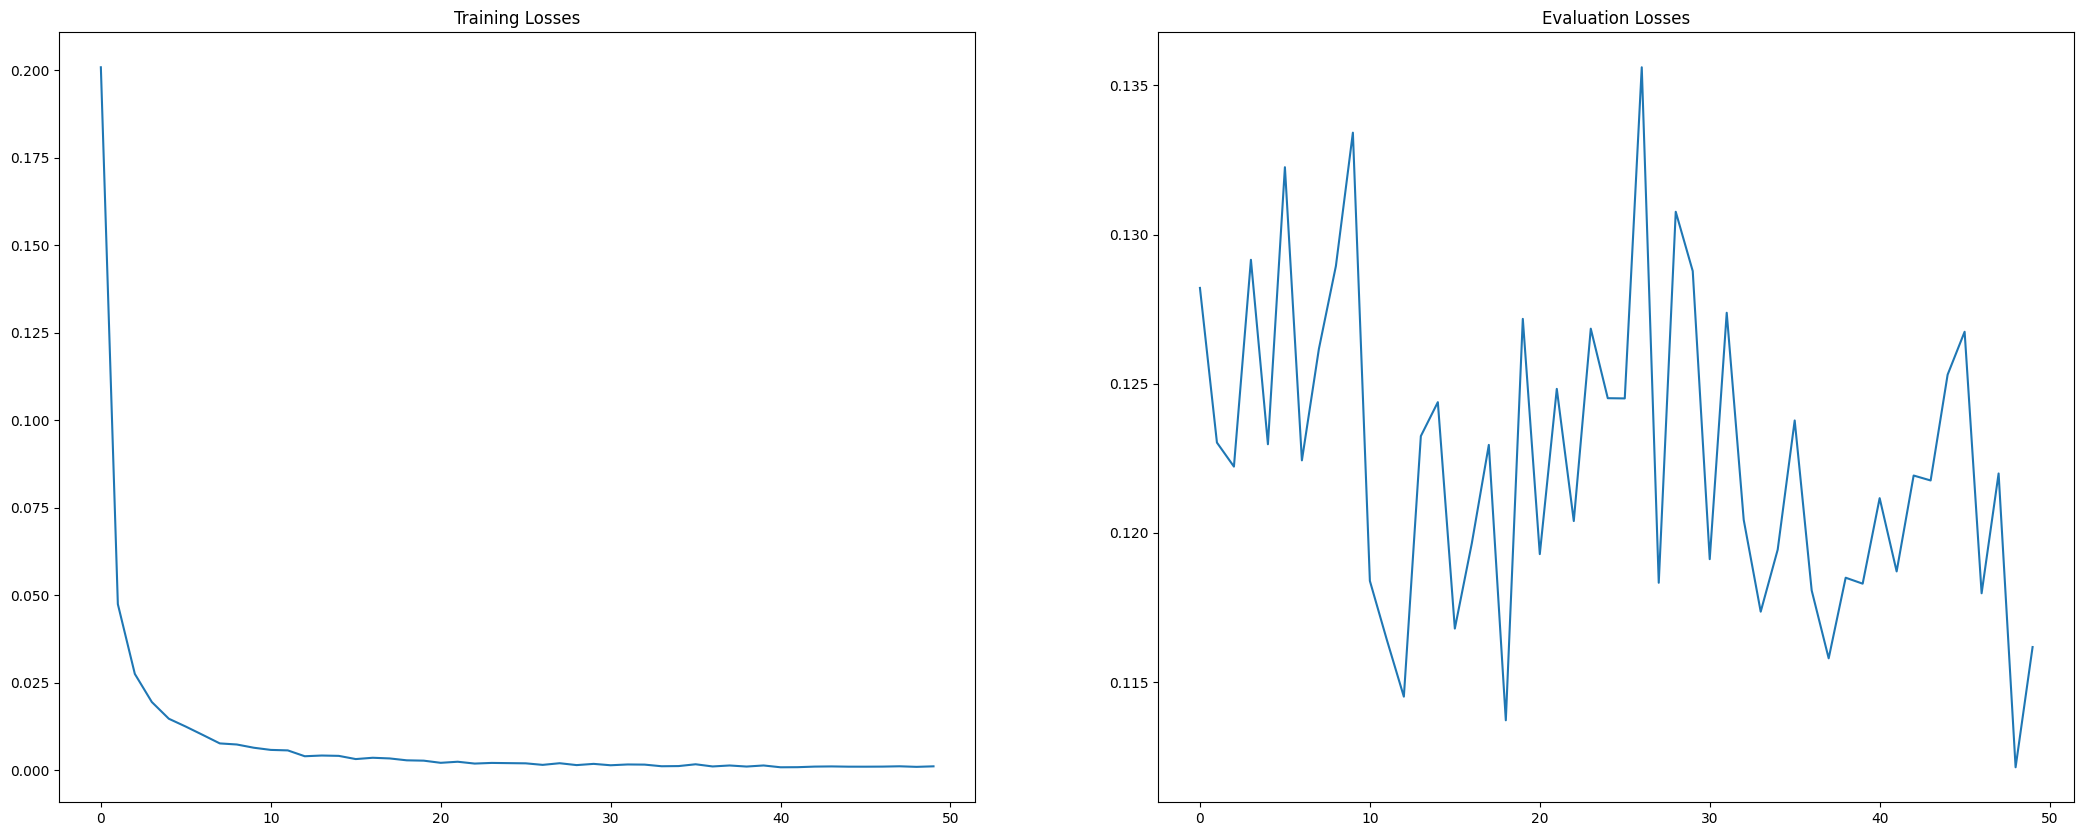

In [ ]:
# Assuming you have defined train_losses and test_losses
x_points_train = np.array([i for i in range(len(train_losses))])
y_points_train = np.array(train_losses)

x_points_validation = np.array([i for i in range(len(test_losses))])
y_points_validation = np.array(test_losses)

# Set a larger figure size directly in subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 10))  # Adjust width and height as needed
ax1.plot(x_points_train, y_points_train)
ax1.set_title('Training Losses')
ax2.plot(x_points_validation, y_points_validation)
ax2.set_title('Evaluation Losses')

plt.show()


<p> Then we reduce the dimension of our pre-trained and fine-tuned, using PCA method, to be able to visualize them in 3D space. </p>
<p> First we perform this visual test on the train portion of data. The first image is related to pre-trained data, and two cells after that, the graph is corresponded to the fine-tuned embedding.
It is clear that in the latter embedding, clusters of fake and true news are better separated.

<p> The 0 label means the data was labeled truth, and 1 means it was labeled fake.

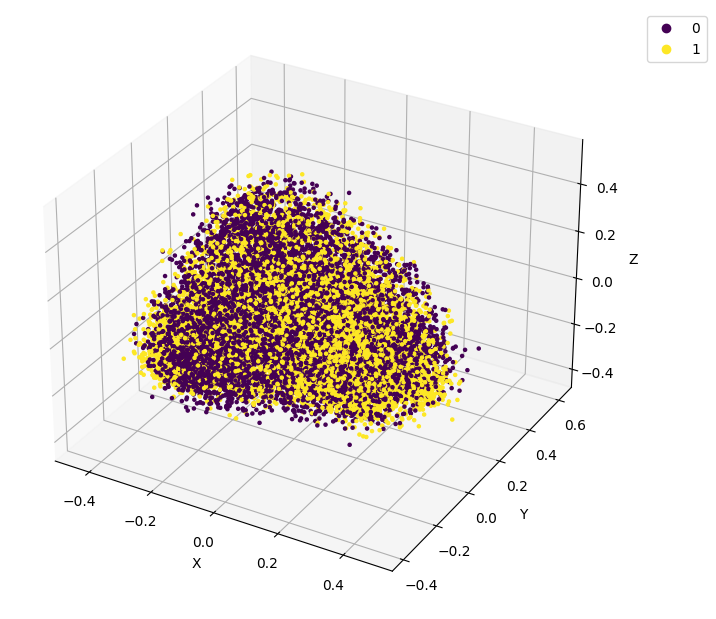

In [ ]:
# generate data
n_components = 3
x_np = np.array(x_train.tolist())
x_dim_reduced = PCA(n_components=n_components).fit_transform(x_np)

colors = np.array(list(chain(y_train.tolist())))

x_fig = x_dim_reduced[:, 0]
y_fig = x_dim_reduced[:, 1]
z_fig = x_dim_reduced[:, 2]

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
# plot
sc = ax.scatter(x_fig, y_fig, z_fig, s=5, c=colors, marker='o', alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

<p> As the last state of model in memory may not be in-sync with the best stored model weigths in the siamese_model.pth, we should reload it before embedding our data.</p>

In [ ]:
siamese_net = SiameseNetwork().to(device)
siamese_net.eval()

siamese_net.load_state_dict(torch.load("siamese_model.pth"))
batch_size = 64


encoded = []
for i in tqdm(range(0, len(x_train), batch_size)):
    encoded.extend(np.array(siamese_net(x_train[i:i+batch_size], x_train[i:i+batch_size])[0].cpu().detach()))

100%|██████████| 260/260 [00:00<00:00, 529.00it/s]


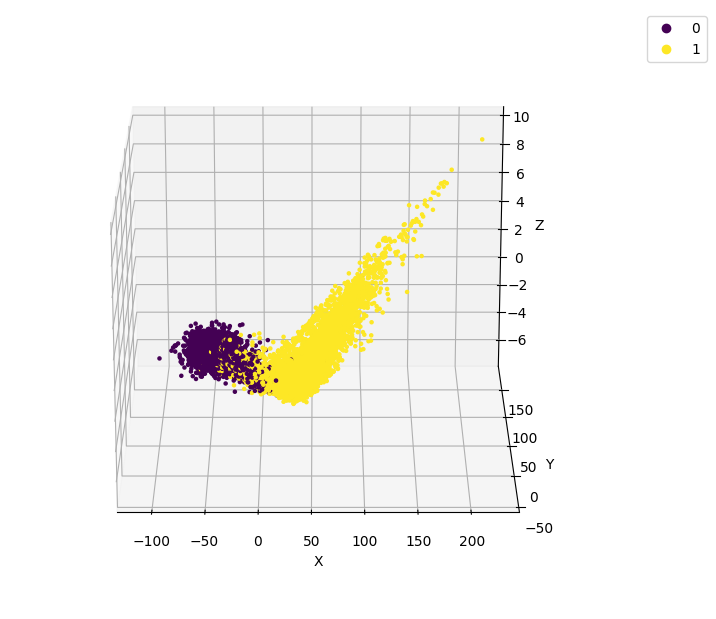

In [ ]:
# generate data
n_components = 3
x_np = np.array(encoded)
x_dim_reduced = PCA(n_components=n_components).fit_transform(x_np)

colors = np.array(list(chain(y_train.tolist())))

x_fig = x_dim_reduced[:, 0]
y_fig = x_dim_reduced[:, 1]
z_fig = x_dim_reduced[:, 2]

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
# plot
sc = ax.scatter(x_fig, y_fig, z_fig, s=5, c=colors, marker='o', alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
ax.view_init(elev=20, azim=270)  # Set the initial viewing angle
# azim 80 or 270
plt.show()

<p> Now we will make the same comparison, but this time between test portion of data. </p>

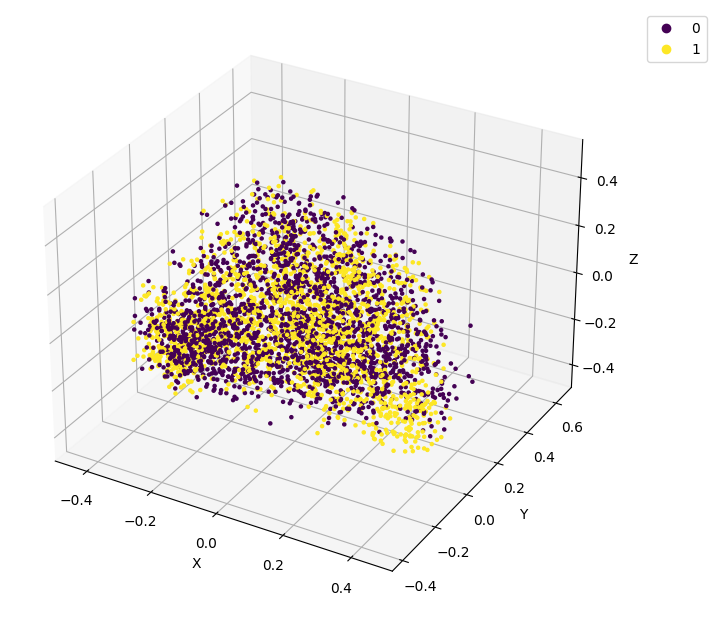

In [ ]:
# generate data
n_components = 3
x_np = np.array(x_valid.tolist())
x_dim_reduced = PCA(n_components=n_components).fit_transform(x_np)

colors = np.array(list(chain(y_valid.tolist())))

x_fig = x_dim_reduced[:, 0]
y_fig = x_dim_reduced[:, 1]
z_fig = x_dim_reduced[:, 2]

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
# plot
sc = ax.scatter(x_fig, y_fig, z_fig, s=5, c=colors, marker='o', alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

We need to get the fine-tuned embedding of the test data as well.

In [ ]:
encoded = []
for i in tqdm(range(0, len(x_valid), batch_size)):
    encoded.extend(np.array(siamese_net(x_valid[i:i+batch_size], x_valid[i:i+batch_size])[0].cpu().detach()))

100%|██████████| 65/65 [00:00<00:00, 241.84it/s]


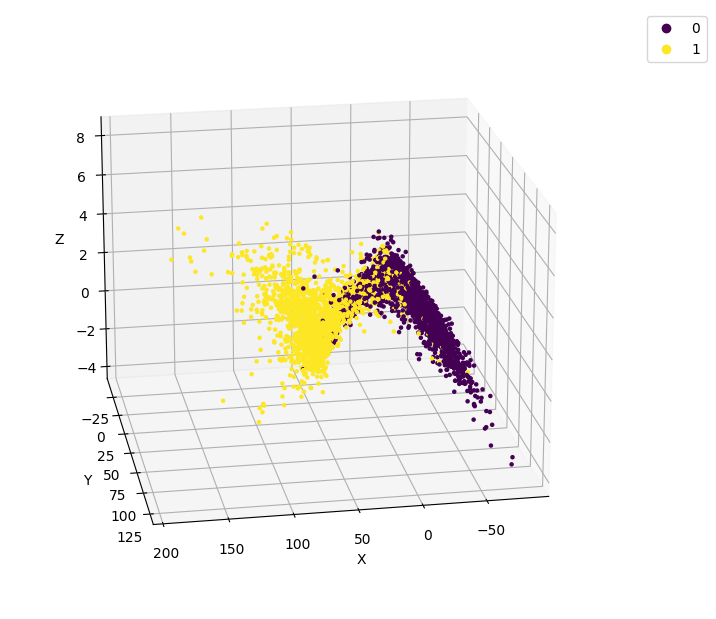

In [ ]:
# generate data
n_components = 3
x_np = np.array(encoded)
x_dim_reduced = PCA(n_components=n_components).fit_transform(x_np)

colors = np.array(list(chain(y_valid.tolist())))

x_fig = x_dim_reduced[:, 0]
y_fig = x_dim_reduced[:, 1]
z_fig = x_dim_reduced[:, 2]

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
# plot
sc = ax.scatter(x_fig, y_fig, z_fig, s=5, c=colors, marker='o', alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

ax.view_init(elev=20, azim=80)  # Set the initial viewing angle
plt.show()

<p> Then, we get the embedding for the whole data (train+test). We want to check some metrics.
</p>

In [ ]:
def get_metrics_embedding(x, y):
  num_classes = len(torch.unique(y))
  class_indices = [torch.where(y == i)[0] for i in range(num_classes)]

  x_truth = x[class_indices[0]]
  x_fake = x[class_indices[1]]

  mean_x_truth = torch.mean(x_truth, axis=0)
  mean_x_fake = torch.mean(x_fake, axis=0)
  euclidean_distance = nn.PairwiseDistance(2)

#   distances_fakes_mean_fake = torch.norm(x_fake - mean_x_fake, dim=1)
  distances_fakes_mean_fake = euclidean_distance(x_fake, mean_x_fake)
  mean_dist_fakes_mean_fake = torch.mean(distances_fakes_mean_fake).item()

#   distances_truth_mean_truth = torch.norm(x_truth - mean_x_truth, dim=1)
  distances_truth_mean_truth = euclidean_distance(x_truth, mean_x_truth)
  mean_dist_truth_mean_truth = torch.mean(distances_truth_mean_truth).item()

#   distances_fakes_mean_truth = torch.norm(x_fake - mean_x_truth, dim=1)
  distances_fakes_mean_truth = euclidean_distance(x_fake, mean_x_truth)
  mean_dist_fakes_mean_truth = torch.mean(distances_fakes_mean_truth).item()

#   distances_truth_mean_fake = torch.norm(x_truth - mean_x_fake, dim=1)
  distances_truth_mean_fake = euclidean_distance(x_truth, mean_x_fake)
  mean_dist_truth_mean_fake = torch.mean(distances_truth_mean_fake).item()

  print("Average Distance of:\n data\\mean \t fake \t|\t truth")
  print("fake \t ", mean_dist_fakes_mean_fake, "\t", mean_dist_fakes_mean_truth)
  print("truth \t ", mean_dist_truth_mean_fake, "\t", mean_dist_truth_mean_truth)

In [ ]:
siamese_net = SiameseNetwork().to(device)
siamese_net.eval()

siamese_net.load_state_dict(torch.load("siamese_model.pth"))
# batch_size = 64

encoded = []
for i in tqdm(range(0, len(x_data), batch_size)):
    encoded.extend(siamese_net(x_data[i:i+batch_size], x_data[i:i+batch_size])[0])
encoded = torch.stack(encoded)

100%|██████████| 325/325 [00:00<00:00, 589.89it/s]


In [ ]:
get_metrics_embedding(x_data, y_data)

Average Distance of:
 data\mean 	 fake 	|	 truth
fake 	  0.8864365220069885 	 0.8997085094451904
truth 	  0.9015119671821594 	 0.8882264494895935


In [ ]:
get_metrics_embedding(encoded, y_data)

Average Distance of:
 data\mean 	 fake 	|	 truth
fake 	  28.48078155517578 	 79.56817626953125
truth 	  78.95916748046875 	 21.792648315429688


In [ ]:
encoded.shape

torch.Size([20800, 512])

In [ ]:
y_data.shape

torch.Size([20800])

<h2> Classification Task Using Binary Classifier Network
 </h2>
<p> We aim to compare the results of our fine-tuned and the pre-trained embedding of this dataset. </p>

In [ ]:
class BinaryClassifier(nn.Module):
    def __init__(self, dropout = .2):
        super(BinaryClassifier, self).__init__()
        self.fwd = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.fwd(x)
        x = torch.sigmoid(x)  # Sigmoid activation for binary classification
        return x

class BinaryClassifier2(nn.Module):
    def __init__(self, dropout):
        super(BinaryClassifier2, self).__init__()
        self.fwd = nn.Sequential(
            nn.Linear(768, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.fwd(x)
        x = torch.sigmoid(x)  # Sigmoid activation for binary classification
        return x

In [ ]:
x_data = []
with open('/content/drive/MyDrive/nlp3/x_train_embedded2.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        x_data.append([float(i) for i in row])
x_data = torch.tensor(x_data)

In [ ]:
y_data = []
with open('/content/drive/MyDrive/nlp3/y_train_embedded.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        y_data.append([float(i) for i in row])
y_data = torch.tensor(y_data)
y_data = y_data.reshape(-1)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.20, random_state=42)
x_train = torch.FloatTensor(x_train).to(device)
x_valid = torch.FloatTensor(x_valid).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_valid = torch.FloatTensor(y_valid).to(device)
y_valid = y_valid.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
print("Training data shape: ", x_train.shape)
print("Validation data shape: ", x_valid.shape)
print("Training label shape: ", y_train.shape)
print("Validation label shape: ", y_valid.shape)

Training data shape:  torch.Size([16640, 768])
Validation data shape:  torch.Size([4160, 768])
Training label shape:  torch.Size([16640, 1])
Validation label shape:  torch.Size([4160, 1])


In [ ]:
siamese_net = SiameseNetwork().to(device)
siamese_net.eval()

siamese_net.load_state_dict(torch.load("siamese_model.pth"))
batch_size = 64

encoded_train = []
for i in tqdm(range(0, len(x_train), batch_size)):
    encoded_train.extend(siamese_net(x_train[i:i+batch_size], x_train[i:i+batch_size])[0])
encoded_train = torch.stack(encoded_train)

encoded_valid = []
for i in tqdm(range(0, len(x_valid), batch_size)):
    encoded_valid.extend(siamese_net(x_valid[i:i+batch_size], x_valid[i:i+batch_size])[0])
encoded_valid = torch.stack(encoded_valid)


100%|██████████| 65/65 [00:00<00:00, 545.08it/s]


<h3> Classification with Fine-tuned Embedding</h3>

In [ ]:
model = BinaryClassifier(dropout = .3)
model.to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.AdamW(model.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

training_losses = []
validation_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero the gradients
    outputs = model(encoded_train)  # Forward pass
    loss = criterion(outputs, y_train)  # Calculate the loss
    training_losses.append(loss.item())
    loss.backward(retain_graph=True)  # Backpropagation with retention
    optimizer.step()  # Update weights
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item()}')

    with torch.no_grad():
        model.eval()
        outputs_valid = model(encoded_valid)
        loss_valid = criterion(outputs_valid, y_valid)  # Calculate the loss
        validation_losses.append(loss_valid.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {loss_valid.item()}')

        if loss_valid <= min(validation_losses):
            torch.save(model.state_dict(), "BinaryClassifier.pth")
    model.train()

Epoch [2/100], Training Loss: 1.2105991840362549
Epoch [2/100], Test Loss: 0.8770771622657776
Epoch [3/100], Training Loss: 0.6096357107162476
Epoch [3/100], Test Loss: 1.6063629388809204
Epoch [4/100], Training Loss: 1.354577660560608
Epoch [4/100], Test Loss: 1.2328299283981323
Epoch [5/100], Training Loss: 0.7034048438072205
Epoch [5/100], Test Loss: 1.2048044204711914
Epoch [6/100], Training Loss: 0.5914512276649475
Epoch [6/100], Test Loss: 1.413057565689087
Epoch [7/100], Training Loss: 0.6116186380386353
Epoch [7/100], Test Loss: 1.7401237487792969
Epoch [8/100], Training Loss: 0.6559073328971863
Epoch [8/100], Test Loss: 1.8999401330947876
Epoch [9/100], Training Loss: 0.7698025703430176
Epoch [9/100], Test Loss: 2.186229705810547
Epoch [10/100], Training Loss: 0.8778263926506042
Epoch [10/100], Test Loss: 2.4000234603881836
Epoch [11/100], Training Loss: 1.0326155424118042
Epoch [11/100], Test Loss: 2.5829079151153564
Epoch [12/100], Training Loss: 1.0899090766906738
Epoch [12

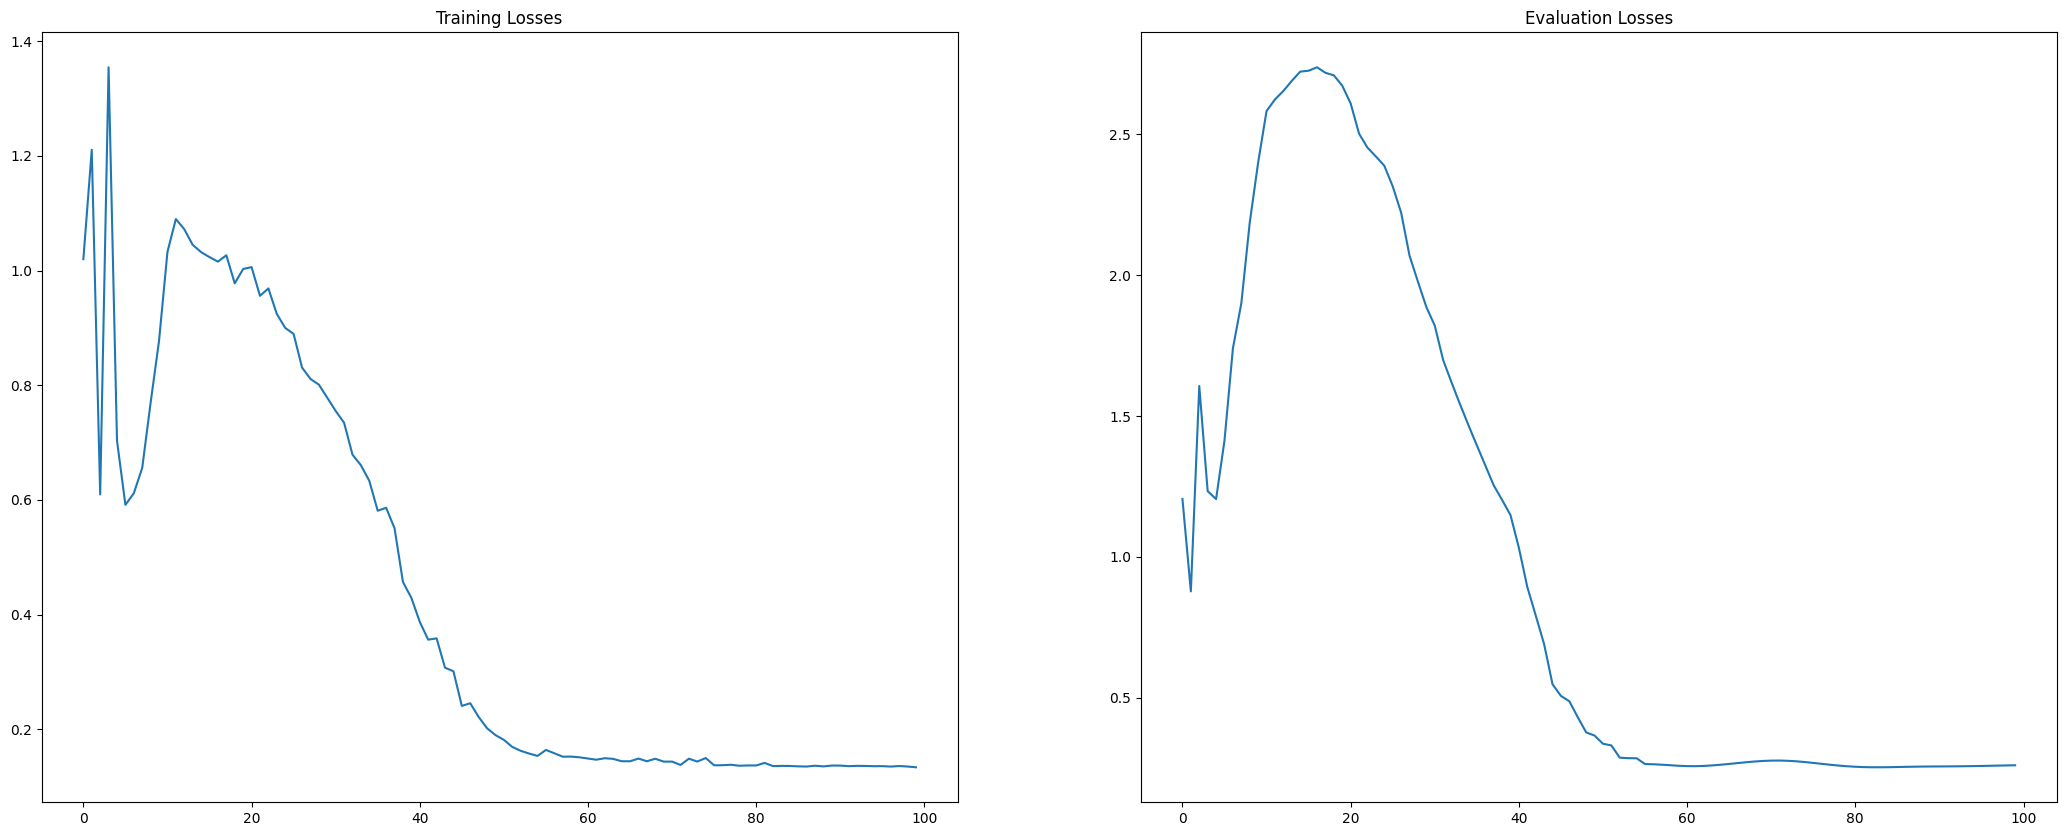

In [ ]:
# Assuming you have defined train_losses and test_losses
x_points_train = np.array([i for i in range(len(training_losses))])
y_points_train = np.array(training_losses)

x_points_validation = np.array([i for i in range(len(validation_losses))])
y_points_validation = np.array(validation_losses)

# Set a larger figure size directly in subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 10))  # Adjust width and height as needed
ax1.plot(x_points_train, y_points_train)
ax1.set_title('Training Losses')
ax2.plot(x_points_validation, y_points_validation)
ax2.set_title('Evaluation Losses')

plt.show()

In [ ]:
model = BinaryClassifier().to(device)
model.load_state_dict(torch.load("BinaryClassifier.pth"))


<All keys matched successfully>

In [ ]:
model.eval()
result = model(encoded_valid) >=.5
pred = []
for i in result:
    if i:
        pred.append(1)
    else:
        pred.append(0)

In [ ]:
print(classification_report(y_valid.cpu(), pred, target_names = ['truth', 'fake']))

              precision    recall  f1-score   support

       truth       0.90      0.92      0.91      2132
        fake       0.92      0.89      0.90      2028

    accuracy                           0.91      4160
   macro avg       0.91      0.91      0.91      4160
weighted avg       0.91      0.91      0.91      4160



<h3> Classification with Pre-trained Embedding</h3>

In [ ]:
model = BinaryClassifier2(dropout = .3)
model.to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.AdamW(model.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

training_losses = []
validation_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero the gradients
    outputs = model(x_train)  # Forward pass
    loss = criterion(outputs, y_train)  # Calculate the loss
    training_losses.append(loss.item())
    loss.backward(retain_graph=True)  # Backpropagation with retention
    optimizer.step()  # Update weights
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item()}')

    with torch.no_grad():
        model.eval()
        outputs_valid = model(x_valid)
        loss_valid = criterion(outputs_valid, y_valid)  # Calculate the loss
        validation_losses.append(loss_valid.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {loss_valid.item()}')

        if loss_valid <= min(validation_losses):
            torch.save(model.state_dict(), "BinaryClassifier.pth")
    model.train()

Epoch [1/100], Training Loss: 0.6938173174858093
Epoch [1/100], Test Loss: 0.6770491003990173
Epoch [2/100], Training Loss: 0.6775074601173401
Epoch [2/100], Test Loss: 0.6526204943656921
Epoch [3/100], Training Loss: 0.6540188193321228
Epoch [3/100], Test Loss: 0.6247923970222473
Epoch [4/100], Training Loss: 0.6274209022521973
Epoch [4/100], Test Loss: 0.5955315232276917
Epoch [5/100], Training Loss: 0.598410427570343
Epoch [5/100], Test Loss: 0.5655952095985413
Epoch [6/100], Training Loss: 0.5689422488212585
Epoch [6/100], Test Loss: 0.536378026008606
Epoch [7/100], Training Loss: 0.5407821536064148
Epoch [7/100], Test Loss: 0.5095146894454956
Epoch [8/100], Training Loss: 0.515227735042572
Epoch [8/100], Test Loss: 0.4860202968120575
Epoch [9/100], Training Loss: 0.4932927191257477
Epoch [9/100], Test Loss: 0.4663824737071991
Epoch [10/100], Training Loss: 0.47451430559158325
Epoch [10/100], Test Loss: 0.4503503143787384
Epoch [11/100], Training Loss: 0.45858636498451233
Epoch [11

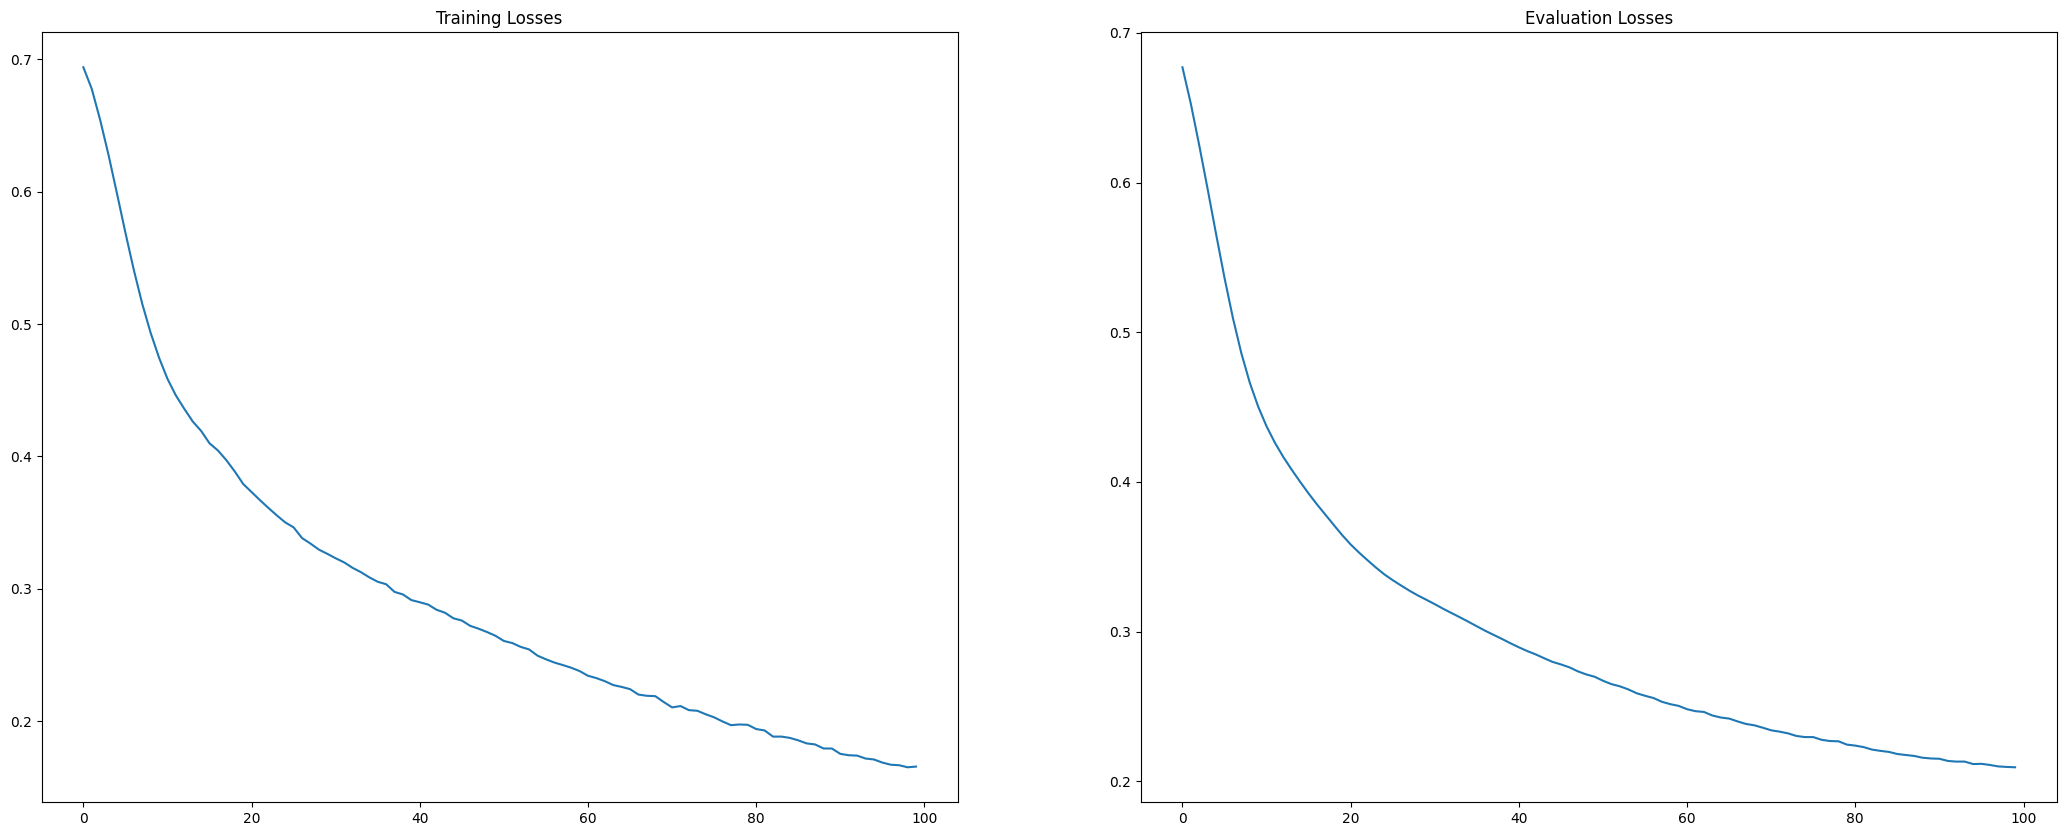

In [ ]:
# Assuming you have defined train_losses and test_losses
x_points_train = np.array([i for i in range(len(training_losses))])
y_points_train = np.array(training_losses)

x_points_validation = np.array([i for i in range(len(validation_losses))])
y_points_validation = np.array(validation_losses)

# Set a larger figure size directly in subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 10))  # Adjust width and height as needed
ax1.plot(x_points_train, y_points_train)
ax1.set_title('Training Losses')
ax2.plot(x_points_validation, y_points_validation)
ax2.set_title('Evaluation Losses')

plt.show()

In [ ]:
model.eval()
result = model(x_valid) >=.5
pred = []
for i in result:
    if i:
        pred.append(1)
    else:
        pred.append(0)

In [ ]:
print(classification_report(y_valid.cpu(), pred, target_names = ['truth', 'fake']))

              precision    recall  f1-score   support

       truth       0.92      0.91      0.92      2132
        fake       0.91      0.92      0.91      2028

    accuracy                           0.91      4160
   macro avg       0.91      0.91      0.91      4160
weighted avg       0.91      0.91      0.91      4160



<p> We can see that our fine-tuned embedding with dimension 512 is giving the same results as the pre-trained embedding with dimension 768. In fact, it shows that we have managed to compress the data while keeping the variance of data which means we have a better embedding on this dataset.
